# SkyMapper - Satellite Infrastructure Detection

Yousra Elzamzami · Hashem Abdelati

CSCI4364 Machine Learning - Fall 2025

This project builds a deep learning pipeline to detect infrastructure from high-resolution satellite imagery. We use the SpaceNet2 dataset, which includes labeled building regions across multiple cities, and train two model families: a ResNet-based CNN and a SegFormer transformer baseline.

The goal is to compare how well convolutional and transformer architectures segment buildings from satellite images using metrics such as Precision, Recall and F1. This notebook handles dataset setup, preprocessing, model training, and initial analysis for the building detection of the project.


#1. Downloading the SpaceNet2 Dataset (Buildings) - Vegas
The SpaceNet2 dataset is very large, the Vegas AOI alone is over 30GB, so we can’t just drag-and-drop it into Colab. SpaceNet hosts the dataset on AWS Open Data, which means the only reliable way to download the files is through AWS’s public bucket links.

SpaceNet’s documentation provides direct download URLs for each AOI, so we use those links to pull the data straight into Google Drive. This matters because Colab resets its storage every session, if we stored the files locally, we’d have to redownload 30GB every single time. By saving everything into Drive once, anyone in the group can reuse the dataset without repeating the download.

Once a single team member runs this step and shares the SkyMapper Drive folder, the AWS download never has to be repeated again. All later preprocessing, mask creation, and model training use the saved files from Drive.

In [ ]:
#Installations
!pip install awscli

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
# VEGAS - AOI 2
# * Run once to download the data. No need to rerun after the files are saved *

# Source - https://spacenet.ai/spacenet-buildings-dataset-v2/
# Training Data
!wget https://spacenet-dataset.s3.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz
#Testing Data
!wget https://spacenet-dataset.s3.amazonaws.com/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz

--2025-12-06 23:04:52--  https://spacenet-dataset.s3.amazonaws.com/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz
Resolving spacenet-dataset.s3.amazonaws.com (spacenet-dataset.s3.amazonaws.com)... 52.216.186.219, 52.217.204.137, 16.15.201.119, ...
Connecting to spacenet-dataset.s3.amazonaws.com (spacenet-dataset.s3.amazonaws.com)|52.216.186.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25640007327 (24G) [application/x-tar]
Saving to: ‘SN2_buildings_train_AOI_2_Vegas.tar.gz’

AOI_2_Vegas.tar.gz    0%[                    ] 141.52M  18.8MB/s    eta 25m 36s^C
--2025-12-06 23:05:02--  https://spacenet-dataset.s3.amazonaws.com/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz
Resolving spacenet-dataset.s3.amazonaws.com (spacenet-dataset.s3.amazonaws.com)... 3.5.29.47, 52.217.195.193, 54.231.195.233, ...
Connecting to spacenet-dataset.s3.amazonaws.com (spacenet-dataset.s3.amazonaws.com)|3.5.29.47|:443... connected.
HTTP requ

In [ ]:
from google.colab import drive
# Mount Google Drive so we can store large datasets permanently
drive.mount('/content/drive')
# Create the SkyMapper folder
!mkdir -p /content/drive/MyDrive/SkyMapper
# Move the downloaded SpaceNet tarballs (training + testing) into the SkyMapper folder
!mv SN2_buildings_train_AOI_2_Vegas.tar.gz /content/drive/MyDrive/SkyMapper/
!mv AOI_2_Vegas_Test_public.tar.gz /content/drive/MyDrive/SkyMapper/
# Confirm the files were actually moved
!du -sh /content/drive/MyDrive/SkyMapper/*

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat 'AOI_2_Vegas_Test_public.tar.gz': No such file or directory
^C


In [ ]:
# Unpacks the compressed dataset into folders we can use
#Extract Training
!tar -xvf /content/drive/MyDrive/SkyMapper/SN2_buildings_train_AOI_2_Vegas.tar.gz -C /content/drive/MyDrive/SkyMapper/
#Extract Testing
!tar -xvf /content/drive/MyDrive/SkyMapper/AOI_2_Vegas_Test_public.tar.gz -C /content/drive/MyDrive/SkyMapper/

AOI_2_Vegas_Train/
AOI_2_Vegas_Train/RGB-PanSharpen/
AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5624.tif
^C
AOI_2_Vegas_Test_public/
AOI_2_Vegas_Test_public/RGB-PanSharpen/
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5578.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img4070.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img2510.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img3906.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1869.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img2213.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1282.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1140.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5188.tif
AOI_2_Vegas_Test_public/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1613.tif
AOI_2_Vegas_Test_public/RGB

## 1.1 Preparing SpaceNet Data: Structure, Images, and Masks

We unzip the SpaceNet folders and reorganize them because the raw download isn’t in a machine-learning format. Images live in one folder, building labels are GeoJSON polygons in another, and models can’t use that directly. So we point to the RGB tiles we need, grab the matching GeoJSON footprint files, and convert everything into a clean images/ and masks/ structure before any preprocessing.

In [ ]:
# Creating the image and mask folders (2 folders for each training and testing)
!mkdir -p /content/drive/MyDrive/SkyMapper/train/images
!mkdir -p /content/drive/MyDrive/SkyMapper/train/masks
!mkdir -p /content/drive/MyDrive/SkyMapper/test/images
!mkdir -p /content/drive/MyDrive/SkyMapper/test/masks

In [ ]:
# Copying the train images
!cp /content/drive/MyDrive/SkyMapper/AOI_2_Vegas_Train/RGB-PanSharpen/*.tif \
    /content/drive/MyDrive/SkyMapper/train/images/

cp: cannot stat '/content/drive/MyDrive/SkyMapper/AOI_2_Vegas_Train/RGB-PanSharpen/*.tif': No such file or directory


In [ ]:
# let you read the TIFF files and convert the GeoJSON building polygons into masks
!pip install rasterio geopandas shapely fiona pyproj tqdm

In [ ]:
# rasterio lets us read the .tif satellite images
import rasterio
from rasterio import features
# geopandas reads the geojson files (these hold the building outlines as polygons)
import geopandas as gpd
import numpy as np
import os
# tqdm just gives us a loading bar so we know the loop is running
from tqdm import tqdm

# folder where the original spacenet training data lives
train_folder = "/content/drive/MyDrive/SkyMapper/AOI_2_Vegas_Train/"
# our cleaned/organized image folder (we already copied the rgb .tif files here)
img_dir = "/content/drive/MyDrive/SkyMapper/train/images/"
# where we want to save the masks we generate
mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks/"

# geojson folder that has the building footprint polygons
# BUT note: the building files are named "buildings_AOI_2_Vegas_imgXXXX.geojson"
geojson_dir = os.path.join(train_folder, "geojson/buildings")

# go through every image in our training folder
for img_file in tqdm(os.listdir(img_dir)):
    # skip anything that isn't a .tif image
    if not img_file.endswith(".tif"):
        continue

    # example filename:
    #   RGB-PanSharpen_AOI_2_Vegas_img6402.tif
    # extract the unique tile id (img6402) → needed to match GeoJSON
    tile_id = img_file.split("RGB-PanSharpen_AOI_2_Vegas_")[-1].replace(".tif", "")

    # build the correct geojson filename
    # expected format:
    #   buildings_AOI_2_Vegas_img6402.geojson
    geo_file = f"buildings_AOI_2_Vegas_{tile_id}.geojson"
    geo_path = os.path.join(geojson_dir, geo_file)

    # open the satellite image to get its size/shapes
    # this tells us how big the mask should be
    img_path = os.path.join(img_dir, img_file)

    with rasterio.open(img_path) as src:
        img_profile = src.profile
        mask = np.zeros((src.height, src.width), dtype=np.uint8)  # empty mask

    # if this image has a matching geojson file with building outlines
    if os.path.exists(geo_path):
        gdf = gpd.read_file(geo_path)
        # convert each polygon into a format rasterio can turn into pixels
        shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]
        # rasterize = turn polygons → 0/1 pixel mask the same size as the image
        mask = features.rasterize(
            shapes,
            out_shape=mask.shape,
            transform=img_profile["transform"],  # keeps mask aligned with image
        )

    # save the mask as a new .tif file next to the images
    out_mask_path = os.path.join(mask_dir, img_file.replace(".tif", "_mask.tif"))
    with rasterio.open(
        out_mask_path,
        "w",
        driver="GTiff",
        height=mask.shape[0],
        width=mask.shape[1],
        count=1,
        dtype=mask.dtype,
        transform=img_profile["transform"],  # same alignment as input image
        crs=img_profile["crs"],
    ) as dst:
        dst.write(mask, 1)


0it [00:00, ?it/s]


In [ ]:
#sanity check - masking went wrong the first time
import os, rasterio, numpy as np

mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks/"

samples = sorted([f for f in os.listdir(mask_dir) if f.endswith(".tif")])[:10]

for m in samples:
    with rasterio.open(os.path.join(mask_dir, m)) as src:
        arr = src.read(1)
        print(m, np.unique(arr))


RGB-PanSharpen_AOI_2_Vegas_img1000_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1002_mask.tif [0.]
RGB-PanSharpen_AOI_2_Vegas_img1003_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1004_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1007_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1009_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1010_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1015_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1016_mask.tif [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1017_mask.tif [0 1]


we randomly load one image-mask pair to make sure the rgb tile and the generated  mask actually line up. this helps us catch broken masks, size mismatches, or incorrect geojson pairings before training the model.


Image: RGB-PanSharpen_AOI_2_Vegas_img2934.tif
Mask: RGB-PanSharpen_AOI_2_Vegas_img2934_mask.tif


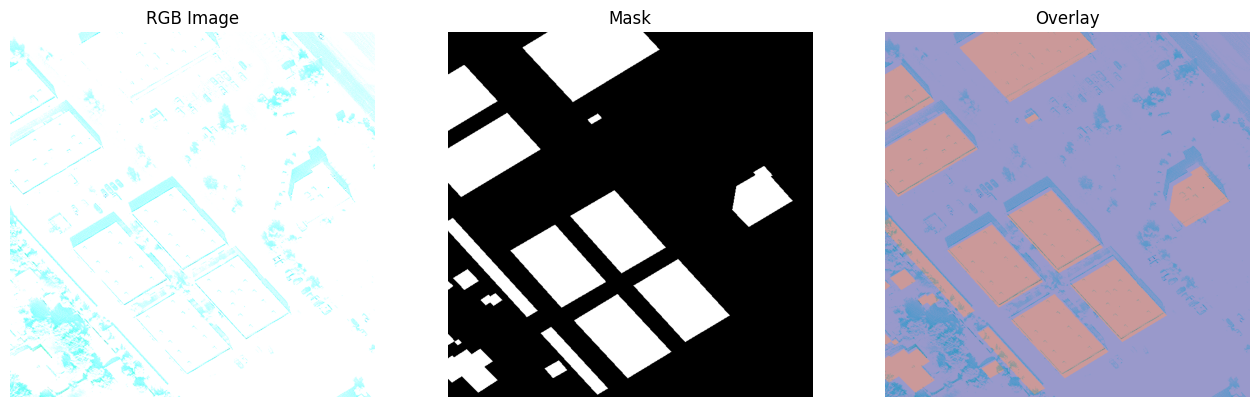

In [ ]:
# checking if i can actually see the images lol
# this whole block is just for visual sanity-check — making sure the images loaded
# correctly and the masks we generated actually line up with the buildings.
import random
import os
import matplotlib.pyplot as plt
import rasterio

img_dir = "/content/drive/MyDrive/SkyMapper/train/images/"
mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks/"

# pick a random .tif image from our training images folder
random_img = random.choice([f for f in os.listdir(img_dir) if f.endswith(".tif")])
img_path = os.path.join(img_dir, random_img)

# build the matching mask filename (same name but with _mask at the end)
base = random_img.replace(".tif", "")
mask_path = os.path.join(mask_dir, base + "_mask.tif")

print("Image:", random_img)
print("Mask:", os.path.basename(mask_path))

# open and read the rgb satellite image
with rasterio.open(img_path) as src:
     # get RGB channels
    img = src.read([1,2,3])
    # reshape so matplotlib can display it
    img = img.transpose(1, 2, 0)
# open and read the mask (single channel)
with rasterio.open(mask_path) as src:
    mask = src.read(1)

# make 3 plots side-by-side
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

# show the rgb tile
ax[0].imshow(img)
ax[0].set_title("RGB Image")
ax[0].axis("off")
# show the mask (0/1 pixels)
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(img)
# overlay the mask on top of the image to check alignment
ax[2].imshow(mask, cmap="jet", alpha=0.4)
ax[2].set_title("Overlay")
ax[2].axis("off")

plt.show()


Using image: RGB-PanSharpen_AOI_2_Vegas_img1284.tif
Using mask: RGB-PanSharpen_AOI_2_Vegas_img1284_mask.tif


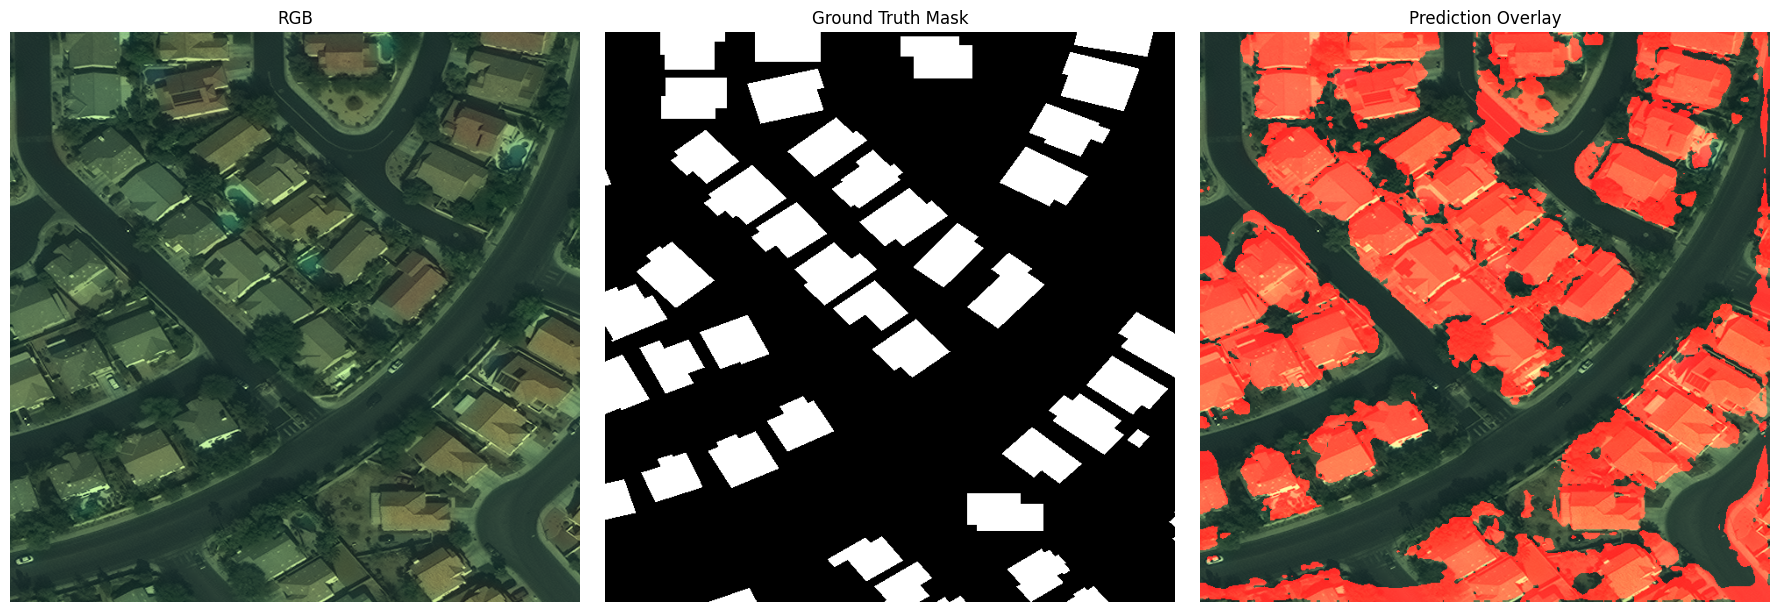

In [ ]:
import os, random, rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- directories ---
img_dir = "/content/drive/MyDrive/SkyMapper/train/images"
mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks"

# --- randomly pick one RGB image ---
img_file = random.choice([f for f in os.listdir(img_dir) if f.endswith(".tif")])
img_path = os.path.join(img_dir, img_file)

# --- construct mask filename ---
mask_file = img_file.replace(".tif", "_mask.tif")
mask_path = os.path.join(mask_dir, mask_file)

print("Using image:", img_file)
print("Using mask:", mask_file)

# --- load RGB with rasterio ---
with rasterio.open(img_path) as src:
    rgb = src.read([1,2,3])  # bands 1,2,3 = RGB

rgb = np.transpose(rgb, (1,2,0)).astype(float)

# fix scaling for visuals
rgb_disp = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

# convert to tensor for model
rgb_tensor = torch.tensor(rgb_disp).permute(2,0,1).unsqueeze(0).float().to(device)

# --- load mask ---
with rasterio.open(mask_path) as src:
    mask = src.read(1)

# --- run SegFormer prediction ---
segformer.eval()
with torch.no_grad():
    logits = segformer(pixel_values=rgb_tensor).logits

# upsample prediction
logits_up = torch.nn.functional.interpolate(
    logits,
    size=mask.shape,
    mode="bilinear",
    align_corners=False
)

pred = (torch.sigmoid(logits_up) >= 0.5).float()[0,0].cpu().numpy()

# --- overlay prediction ---
overlay = rgb_disp.copy()
overlay[:,:,0] = np.maximum(overlay[:,:,0], pred)  # add red channel for prediction

# --- plot everything ---
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(rgb_disp)
plt.title("RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Prediction Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
!find /content/drive/MyDrive -name "*.tif" | head -20

# 2. Data Preparation

This section prepares the SpaceNet dataset so it can be used for model training. First, we split the images into training, validation, and testing sets to ensure the model is evaluated fairly. Next, we apply normalization and resizing so all images share the same scale and dimensions because deep learning models expect every input image to be the exact same size and roughly the same brightness range. If we fed the model random image sizes or wildly different pixel values, it wouldn’t be able to batch them together or learn consistent patterns.

After that, we build a custom PyTorch dataset class to load each image–mask pair with the right transforms and then use DataLoaders to efficiently feed batches into the model during training.

Before we work with the dataset, we mount Google Drive inside Colab so the notebook can access files stored in our Drive folder. This is important because Colab’s local storage resets whenever the runtime disconnects, which would force us to redownload and regenerate masks repeatedly. By using Drive, the dataset, processed images/ and masks/ folders, and any saved model checkpoints remain available across sessions

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## 2.1 - Train/Val/Test Split

Before training the model, we divide the dataset into three groups: training, validation, and testing. Since we have thousands of image–mask pairs, we shuffle the full list using a fixed random seed (so the split is reproducible) and then divide them using an 80/10/10 ratio. This gives the model enough data to learn from while still keeping separate examples for validation and evaluation.

Before we work with the SpaceNet dataset, we mount Google Drive inside Colab so the notebook can access files stored in our Drive folder. This is important because Colab’s local storage resets whenever the runtime disconnects, which would force us to redownload and regenerate masks repeatedly. By using Drive, the dataset, processed images/ and masks/ folders, and any saved model checkpoints remain available across sessions

In [ ]:
import os
import random

img_dir = "/content/drive/MyDrive/SkyMapper/train/images/"
mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks/"

# get every image filename in the folder (only .tif files)
all_imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])

# set a random seed so the shuffle is always the same every time you run it
random.seed(42)
random.shuffle(all_imgs)

# figure out how many images go into each split (80% train, 10% val, 10% test)
n = len(all_imgs)
train_split = int(0.8 * n)
val_split = int(0.9 * n)

# slice the list into train, val, and test groups
train_files = all_imgs[:train_split]
val_files   = all_imgs[train_split:val_split]
test_files  = all_imgs[val_split:]

print(f"Total images: {n}")
print(f"Train: {len(train_files)}")
print(f"Val:   {len(val_files)}")
print(f"Test:  {len(test_files)}")


Total images: 3848
Train: 3078
Val:   385
Test:  385


## 2.2 - Normalization and Resizing

We normalize and resize every image so they all have the same pixel range and dimensions, which deep learning models require to train stably and batch images together.

In [ ]:
import torch
import torchvision.transforms as T

# these transforms clean and standardize the images before they go into the model
# Source: https://pytorch.org/vision/stable/transforms.html
transform_img = T.Compose([
    # turn the image into a pytorch tensor (needed for all models)
    T.ToTensor(),
    # make sure the tensor is stored as float32
    T.ConvertImageDtype(torch.float32),
    # resize every image to the same size so batching works
    T.Resize((256, 256)),
     # normalize pixel values so brightness/contrast is on a stable scale
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
# masks need their own transform because they are not rgb images
transform_mask = T.Compose([
    T.ToTensor(),
    # resize mask to match the image; use nearest-neighbor so we don't blur labels
    # Source: https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html
    T.Resize((256, 256), antialias=False)
])


## 2.3 - PyTorch Dataset Class

We create a custom Dataset class that loads each image–mask pair from disk, applies the transforms, and returns them in a format the model can use.

In [ ]:
from torch.utils.data import Dataset
import rasterio
# dataset class for loading spacenet images + masks
# Source: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
class SpaceNetDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, transform_img=None, transform_mask=None):
        # save the list of filenames and folder paths
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        # save the image + mask transforms (normalization, resizing, etc.)
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        # return how many items are in the dataset
        return len(self.file_list)

    def __getitem__(self, idx):
        # get the filename at the given index
        img_name = self.file_list[idx]
        # build the full paths to the image and mask
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".tif", "_mask.tif"))

        # load the rgb image (channels 1,2,3) and move axes so it's height x width x channels
        with rasterio.open(img_path) as src:
            img = src.read([1,2,3]).transpose(1, 2, 0)

        # load the mask
        # Source: https://gis.stackexchange.com/questions/246559/is-it-possible-to-read-in-specific-bands-from-a-multi-band-raster-with-gdal-or-r
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
        # apply image transforms if provided
        if self.transform_img:
            img = self.transform_img(img)
        # apply mask transforms + convert it to binary 0/1
        if self.transform_mask:
            mask = self.transform_mask(mask)
            mask = (mask > 0).float()      # convert to 0/1
        # return the processed image and mask as tensors
        return img, mask

In [ ]:
import os
import numpy as np
import rasterio

mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks/"

samples = sorted([f for f in os.listdir(mask_dir) if f.endswith(".tif")])[:10]
print("Sample mask files:", samples)

for m in samples:
    with rasterio.open(os.path.join(mask_dir, m)) as src:
        arr = src.read(1)
        print(m, "unique:", np.unique(arr))


Sample mask files: ['RGB-PanSharpen_AOI_2_Vegas_img1000_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1002_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1003_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1004_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1007_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1009_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1010_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1015_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1016_mask.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1017_mask.tif']
RGB-PanSharpen_AOI_2_Vegas_img1000_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1002_mask.tif unique: [0.]
RGB-PanSharpen_AOI_2_Vegas_img1003_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1004_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1007_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1009_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1010_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1015_mask.tif unique: [0 1]
RGB-PanSharpen_AOI_2_Vegas_img1016_mask.tif uni

## 2.4 - Dataloaders
Supposed to be like TensorFlow’s: ds_train.batch().shuffle()
We wrap the datasets in DataLoaders so PyTorch can efficiently load batches of images and masks during training.

In [ ]:
from torch.utils.data import DataLoader
# wrap each dataset in a pytorch dataset object (this applies transforms + loads img/mask pairs)
train_dataset = SpaceNetDataset(train_files, img_dir, mask_dir, transform_img, transform_mask)
val_dataset   = SpaceNetDataset(val_files,   img_dir, mask_dir, transform_img, transform_mask)
test_dataset  = SpaceNetDataset(test_files,  img_dir, mask_dir, transform_img, transform_mask)
# create dataloaders so pytorch can load data in batches automatically
# batch_size=8 means we feed 8 images/masks to the model at a time
# shuffle only the training set so the model doesn’t see data in the same order every epoch
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# no need to shuffle val/test because we aren’t learning from them

val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)

print("DataLoaders ready!")


DataLoaders ready!


In [ ]:
img, mask = train_dataset[0]  # load the first sample

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("Mask unique values:", mask.unique())

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])
Mask unique values: tensor([0., 1.])


# 3. ResNet Model (Hashem)
In this section, we implement our convolutional baseline: a ResNet-based segmentation model. ResNet is designed to make very deep CNNs trainable by using residual (skip) connections, where each block learns a residual function and outputs F(x)+x. This helps gradients flow through the network during backpropagation and avoids the training degradation problems that appear in deeper architectures.

## Architecture Setup

ResNet-50 is selected as our CNN backbone because its residual block design enables stable optimization for deeper convolutional networks, improving gradient flow during backpropagation. In our segmentation setting, we use ResNet50 as the encoder to extract multi-scale spatial features from satellite tiles, and attach a segmentation head that upsamples these features to produce a dense, pixelwise building mask. Since building extraction is a binary task, the final prediction layer is configured to output a single channel representing building vs. background for each pixel.

In [ ]:
import torch
import torchvision
from torchvision.models import ResNet50_Weights

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# FCN segmentation model with a ResNet-50 backbone
# num_classes=1 -> binary segmentation output (1 logit channel)
# aux_loss=False keeps output simple (just "out")
resnet50_fcn = torchvision.models.segmentation.fcn_resnet50(
    weights=None,
    weights_backbone=ResNet50_Weights.DEFAULT,  # ImageNet pretrained backbone
    num_classes=1,
    aux_loss=False
).to(device)

# Sanity check: run a dummy forward pass and verify shapes
resnet50_fcn.eval()
x = torch.randn(2, 3, 256, 256).to(device)  # batch of 2 fake images
with torch.no_grad():
    y = resnet50_fcn(x)["out"]

print("Model ready:", resnet50_fcn.__class__.__name__)
print("Output shape (should be [B, 1, 256, 256]):", y.shape)


Using device: cuda
Model ready: FCN
Output shape (should be [B, 1, 256, 256]): torch.Size([2, 1, 256, 256])


## Loss Function + Optimizer

The model predicts a logit value per pixel (not a probability yet). During training, we need a loss function that compares these logits to the ground-truth binary mask (0 = background, 1 = building) and gives a strong learning signal when the model misses building pixels or produces false positives. Since this is a binary segmentation problem, a standard choice is Binary Cross-Entropy with Logits, which is numerically stable because it combines the sigmoid operation and cross-entropy in one function.
We also define an optimizer to update model weights via gradient descent. Adam is a reliable default for segmentation tasks because it adapts learning rates per parameter and usually converges faster than plain SGD in early experiments.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Binary segmentation loss (expects raw logits and targets in {0,1})
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(resnet50_fcn.parameters(), lr=1e-4, weight_decay=1e-5)


print("Loss and optimizer initialized.")


Loss and optimizer initialized.


## Training Loop

In this sextion, we train the ResNet 50 segmentation model using a standard mini batch training routine. For each epoch, we loop through batches of image–mask pairs from the training DataLoader, run a forward pass to generate a predicted mask (logits), compute the loss by comparing predictions to the ground-truth masks, and then update the model weights using backpropagation and the optimizer. We track the average training loss across the epoch so we can confirm the model is learning and diagnose issues early (loss not decreasing, exploding values, or data misalignment).

In [ ]:
import torch
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(device)      # [B, 3, H, W]
        masks = masks.to(device)    # [B, 1, H, W]
        masks = (masks > 0.5).float()


        # Forward pass (FCN returns a dict; "out" contains logits)
        logits = model(imgs)["out"]  # [B, 1, H, W]

        # Loss
        loss = criterion(logits, masks)

        # Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


Epoch 1/5 | Train Loss: 0.3261 | Val Loss: 1.8205
Saved ResNet-50 model.

Epoch 2/5 | Train Loss: 0.2476 | Val Loss: 0.9582
Saved ResNet-50 model.

Epoch 3/5 | Train Loss: 0.2170 | Val Loss: 0.6192
Saved ResNet-50 model.

Epoch 4/5 | Train Loss: 0.1965 | Val Loss: 0.6335
                                                          
Epoch 5/5 | Train Loss: 0.1838 | Val Loss: 1.3801

Best epoch: 3 with Val Loss = 0.6192



## Validation Loop

After each training epoch, we evaluate the model on the validation set to estimate how well it generalizes to unseen tiles. Unlike training, validation does not update the model weights. We switch the network into evaluation mode (model.eval()) and disable gradient computation, which makes validation faster and ensures layers like BatchNorm/Dropout behave consistently. We compute the average validation loss across the full validation split and compare it to the training loss to monitor learning progress and detect overfitting early.

In [ ]:
import torch
from tqdm import tqdm

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)
            masks = (masks > 0.5).float()

            logits = model(imgs)["out"]
            loss = criterion(logits, masks)

            running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


**Results 12/07:**
Validation Loss: 2.735027081625802

In [ ]:
num_epochs = 5

train_losses_resnet = []
val_losses_resnet   = []

best_val_loss   = float("inf")
best_epoch      = -1
best_state_dict = None

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        resnet50_fcn,
        train_loader,
        criterion,
        optimizer,
        device
    )
    val_loss = validate_one_epoch(
        resnet50_fcn,
        val_loader,
        criterion,
        device
    )

    train_losses_resnet.append(train_loss)
    val_losses_resnet.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # track best model by validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_state_dict = resnet50_fcn.state_dict()
        torch.save(best_state_dict, "/content/drive/MyDrive/SkyMapper/resnet50_best.pth")
        print("Saved ResNet-50 model.")

print(f"Best epoch: {best_epoch} with Val Loss = {best_val_loss:.4f}")

# load best weights before testing
if best_state_dict is not None:
    resnet50_fcn.load_state_dict(best_state_dict)
    print("Loaded best ResNet-50 checkpoint for evaluation.")


Epoch 1/5 | Train Loss: 0.2480 | Val Loss: 0.2199
Saved ResNet-50 model.


Epoch 2/5 | Train Loss: 0.1614 | Val Loss: 0.2168
Saved ResNet-50 model.


Epoch 3/5 | Train Loss: 0.1383 | Val Loss: 0.1608
Saved ResNet-50 model.


Epoch 4/5 | Train Loss: 0.1230 | Val Loss: 0.1745


Epoch 5/5 | Train Loss: 0.1142 | Val Loss: 0.1678
Best epoch: 3 with Val Loss = 0.1608
Loaded best ResNet-50 checkpoint for evaluation.


In [ ]:
val_loss = validate_one_epoch(resnet50_fcn, val_loader, criterion, device)
print("Validation Loss:", val_loss)

Validation Loss: 1.380058616786808


In [ ]:
print("len(test_dataset) =", len(test_dataset))

batches = 0
for _ in test_loader:
    batches += 1
print("num test batches =", batches)


len(test_dataset) = 385
num test batches = 49


**Results 12/07**:   
len(test_dataset) = 385  
num test batches = 49

In [ ]:
import os, rasterio
import numpy as np

mask_dir = "/content/drive/MyDrive/SkyMapper/train/masks/"
total_sum = 0
nonzero_files = 0

for f in os.listdir(mask_dir):
    if f.endswith(".tif"):
        with rasterio.open(os.path.join(mask_dir, f)) as src:
            m = src.read(1)
            s = m.sum()
            total_sum += s
            if s > 0:
                nonzero_files += 1

print("Total pixel sum across all masks:", total_sum)
print("Number of masks with any nonzero pixel:", nonzero_files)


Total pixel sum across all masks: 307440688.0
Number of masks with any nonzero pixel: 3613


**Results 12/07**:  
Total pixel sum across all masks: 307440688.0
Number of masks with any nonzero pixel: 3613

## Testing (Precision, Recall, F1)

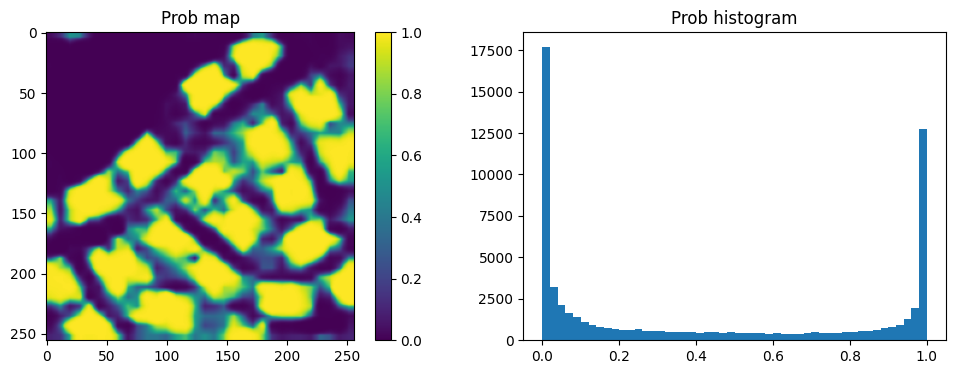

prob min/max/mean: 3.363109e-05 0.9999957 0.42741913


In [ ]:
resnet50_fcn.eval()
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    probs = torch.sigmoid(resnet50_fcn(imgs)["out"])  # [B,1,H,W]

p = probs[0,0].detach().cpu().numpy()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(p, vmin=0, vmax=1); plt.title("Prob map"); plt.colorbar()
plt.subplot(1,2,2); plt.hist(p.flatten(), bins=50); plt.title("Prob histogram")
plt.show()

print("prob min/max/mean:", p.min(), p.max(), p.mean())

In [ ]:
import torch

def compute_prf1_iou(tp, fp, fn, eps=1e-8):
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    iou       = tp / (tp + fp + fn + eps)
    return precision, recall, f1, iou

TP = FP = FN = 0

resnet50_fcn.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)
        masks = (masks > 0.5).float()

        # forward pass (torchvision FCN)
        logits = resnet50_fcn(imgs)["out"]   # [B, 1, H, W]
        probs  = torch.sigmoid(logits)
        preds  = (probs >= 0.5).float()

        # pixel stats
        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision, recall, f1, iou = compute_prf1_iou(TP, FP, FN)

print("=== ResNet-50 Pixel-wise Metrics ===")
print("Precision:", round(precision, 4))
print("Recall:   ", round(recall, 4))
print("F1 Score: ", round(f1, 4))
print("IoU:      ", round(iou, 4))
print("TP, FP, FN:", TP, FP, FN)


=== ResNet-50 Pixel-wise Metrics ===
Precision: 0.7864
Recall:    0.8667
F1 Score:  0.8246
IoU:       0.7016
TP, FP, FN: 4122573.0 1119528.0 633864.0


=== ResNet-50 Pixel-wise Metrics ===

Precision: 0.7864

Recall:    0.8667

F1 Score:  0.8246

IoU:       0.7016

TP, FP, FN: 4122573.0 1119528.0 633864.0

### Loss Curve (ResNet-50)

To summarize how the ResNet-50 model behaved during training, we plot the training loss across epochs. This helps visualize whether the optimization procedure is converging and whether additional epochs are likely to improve performance.


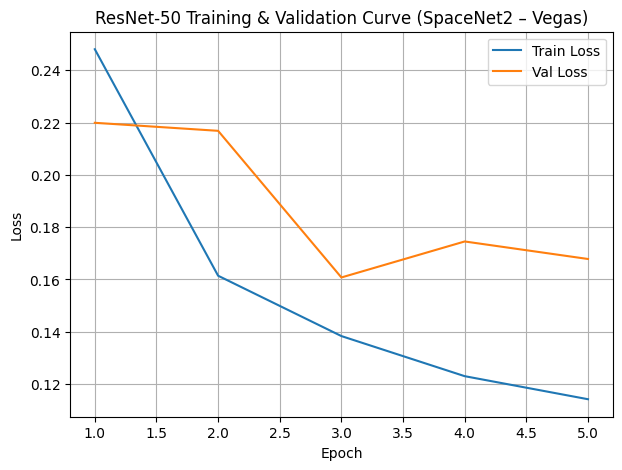

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses_resnet) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses_resnet, label="Train Loss")
plt.plot(epochs, val_losses_resnet, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-50 Training & Validation Curve (SpaceNet2 – Vegas)")
plt.legend()
plt.grid(True)
plt.show()


### Prediction Visuals (ResNet-50)

To qualitatively inspect ResNet-50s predictions, we visualize an example test tile alongside its ground truth mask and the models predicted building mask. This helps us see typical error patterns, such as over-segmentation or missed small structures.


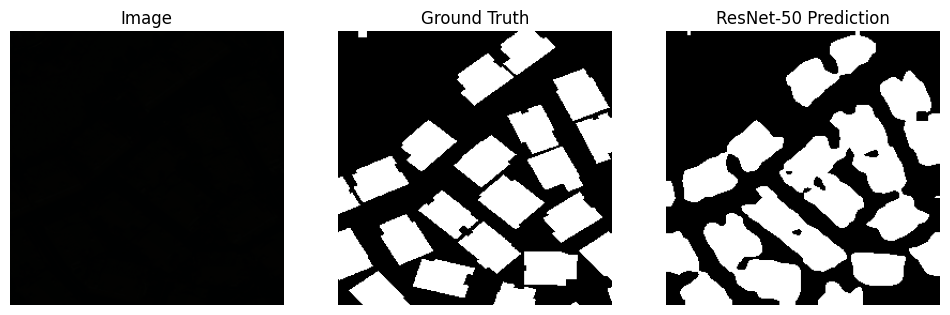

In [ ]:
resnet50_fcn.eval()

imgs, masks = next(iter(val_loader))
imgs  = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = resnet50_fcn(imgs)["out"]
    probs  = torch.sigmoid(logits)
    preds  = (probs >= 0.5).float()

idx = 0  # first image in batch

plt.figure(figsize=(12,4))

# Unnormalize RGB tile
plt.subplot(1,3,1)
plt.imshow((imgs[idx].cpu().permute(1,2,0)*0.5+0.5).clamp(0,1))
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(masks[idx].cpu().squeeze(), cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(preds[idx].cpu().squeeze(), cmap='gray')
plt.title("ResNet-50 Prediction")
plt.axis("off")

plt.show()


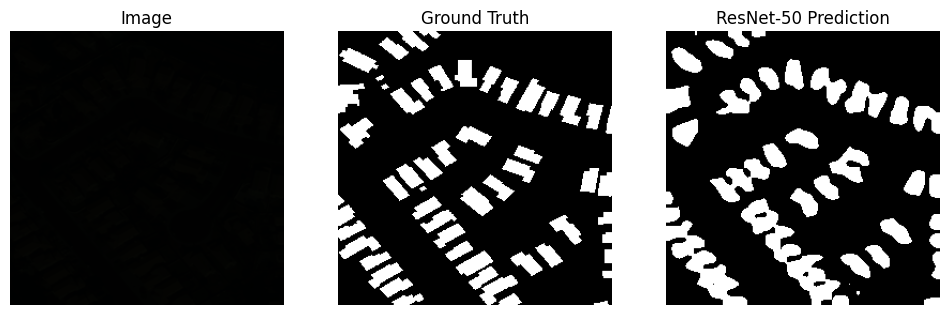

In [ ]:
resnet50_fcn.eval()

imgs, masks = next(iter(val_loader))
imgs  = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = resnet50_fcn(imgs)["out"]
    probs  = torch.sigmoid(logits)
    preds  = (probs >= 0.5).float()

idx = 1  # first image in batch

plt.figure(figsize=(12,4))

# Unnormalize RGB tile
plt.subplot(1,3,1)
plt.imshow((imgs[idx].cpu().permute(1,2,0)*0.5+0.5).clamp(0,1))
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(masks[idx].cpu().squeeze(), cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(preds[idx].cpu().squeeze(), cmap='gray')
plt.title("ResNet-50 Prediction")
plt.axis("off")

plt.show()

# 4. SegFormer Baseline (Yousra)

While our ResNet-50 baseline relies on a traditional CNN, our second model uses a newer approach called SegFormer, which is based on Transformers. The main difference is that CNNs only look at small parts of an image at a time, while SegFormer can take in information from the entire satellite tile at once. This broader view helps the model recognize buildings that vary widely in size, shape, and density, and makes it better suited for complex satellite scenes.


## Architecture Setup

In [ ]:
# install the transformers library for segformer
# source (segformer docs): https://huggingface.co/docs/transformers/model_doc/segformer
!pip install -q transformers timm

I installed the Transformers and timm libraries because SegFormer is implemented through HuggingFace and depends on timm for some backbone layers. I used the SegFormer-B0 checkpoint since it’s the smallest version and runs reliably on Colab without running into memory issues.

The original checkpoint is trained for 150-class segmentation, so I replaced the segmentation head with a single-channel output for our binary building mask. Using ignore_mismatched_sizes=True lets the model load the pretrained encoder while discarding the original classifier.

After moving the model to GPU and switching it to training mode, I ran a quick dummy batch through the forward pass. This check is just to confirm that the model loads correctly, the output shape matches what we expect, and that nothing breaks before training.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation

# use gpu if available?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

# load a small segformer model with pretrained weights
# checkpoint info: https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512
# we override num_labels=1 for binary segmentation (building vs background)
segformer = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    # 1 logit channel → building probability
    num_labels=1,
    # allow resizing the last layer
    ignore_mismatched_sizes=True
)

segformer.to(device)
segformer.train()

# pass a fake batch through
# batch of 2 fake tiles
x_dummy = torch.randn(2, 3, 256, 256).to(device)
with torch.no_grad():
    out_dummy = segformer(pixel_values=x_dummy).logits
print("dummy output shape:", out_dummy.shape)


using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


dummy output shape: torch.Size([2, 1, 64, 64])


## Loss Function + Optimizer

For SegFormer, I used BCEWithLogitsLoss because the model outputs a single logit per pixel and our task is binary segmentation (building vs background). This loss lets the model learn directly from raw logits without needing a sigmoid in the forward pass.

For optimization, I stuck with Adam, but with a slightly lower learning rate than the ResNet model. Transformer-based backbones are more sensitive to large learning rates, so 1e-4 is a safer choice to keep training stable. I also added a small weight decay to help regularize the model and reduce overfitting.

In [ ]:
# binary segmentation loss for logits vs 0/1 masks
criterion_segformer = nn.BCEWithLogitsLoss()

# optimizer: adam again but maybe slightly smaller lr because transformer
optimizer_segformer = torch.optim.Adam(
    segformer.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

print("segformer loss + optimizer ready.")

segformer loss + optimizer ready.


## Training Loop

SegFormer outputs lower-resolution logits, so I upsample them back to 256×256 before computing the loss. The training loop sends each batch through the model using pixel_values, upsamples the predictions, calculates the BCE loss, and updates the weights with Adam.

The validation loop does the same forward pass and upsampling but without gradients. Both functions return the average loss so I can track how the model is performing across epochs.

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# training fn for segformer (just 1 epoch)
# note: segformer outputs logits at ~1/4 resolution = got to upsample
def train_segformer_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0

    # tqdm around loader
    for imgs, masks in tqdm(loader, desc="segformer training", leave=True):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # fwd pass (segformer uses pixel_values, not input_like regular models)
        # (source: hf docs: https://huggingface.co/docs/transformers/model_doc/segformer)
        logits = model(pixel_values=imgs).logits

        # resize segformer output → same size as mask
        logits_up = torch.nn.functional.interpolate(
            logits,
            # resize back to 256x256
            size=masks.shape[-2:],
            mode="bilinear",
            # pytorch forums say keep false for stability
            align_corners=False
        )

        # bce loss w/ logits (recommended for binary seg)
        loss = criterion(logits_up, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

# validation fn (same thing but no gradients)
def validate_segformer(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        # tqdm wrapper
        for imgs, masks in tqdm(loader, desc="segformer validating", leave=True):
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(pixel_values=imgs).logits

            # resize again (segformer always outputs downsampled maps)
            logits_up = torch.nn.functional.interpolate(
                logits,
                size=masks.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            val_loss += criterion(logits_up, masks).item()

    return val_loss / len(loader)

print("segformer training + val fns loaded")

segformer training + val fns loaded


I trained SegFormer for 5 epochs, since transformer-based models usually converge faster than our CNN baseline. After each epoch, I recorded both the training and validation loss so I could compare them later. I also saved a checkpoint at the end of every epoch to avoid retraining if the Colab session resets. The loop simply runs the training function, runs validation, logs the losses, and writes the model weights to Drive.

In [ ]:
import time
import numpy as np

# keeping history so we can plot after
segformer_train_losses = []
segformer_val_losses   = []

save_path = "/content/drive/MyDrive/SkyMapper/segformer_epoch_{}.pth"

# how many epochs?? segformer learns faster than cnn
epochs = 5

print("starting segformer training")

for ep in range(epochs):
    t0 = time.time()

    train_loss = train_segformer_one_epoch(
        segformer,
        train_loader,
        optimizer_segformer,
        criterion_segformer,
        device
    )
    val_loss = validate_segformer(
        segformer,
        val_loader,
        criterion_segformer,
        device
    )

    segformer_train_losses.append(train_loss)
    segformer_val_losses.append(val_loss)

    t1 = time.time()
    print(f"epoch {ep+1}/{epochs} | train={train_loss:.4f} | val={val_loss:.4f} | time={(t1-t0):.1f}s")
    # so I don't have to retrain this
    torch.save(segformer.state_dict(), save_path.format(ep+1))
    print(f"Saved model: {save_path.format(ep+1)}")

print("done training segformer")


starting segformer training


segformer validating: 100%|██████████| 49/49 [02:04<00:00,  2.53s/it]


epoch 1/5 | train=0.5148 | val=0.4853 | time=1867.5s
Saved model: /content/drive/MyDrive/SkyMapper/segformer_epoch_1.pth


segformer validating: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it]


epoch 2/5 | train=0.3129 | val=0.2264 | time=736.4s
Saved model: /content/drive/MyDrive/SkyMapper/segformer_epoch_2.pth


segformer validating: 100%|██████████| 49/49 [01:31<00:00,  1.86s/it]


epoch 3/5 | train=0.2220 | val=0.1936 | time=722.9s
Saved model: /content/drive/MyDrive/SkyMapper/segformer_epoch_3.pth


segformer validating: 100%|██████████| 49/49 [00:52<00:00,  1.07s/it]


epoch 4/5 | train=0.1919 | val=0.1873 | time=679.4s
Saved model: /content/drive/MyDrive/SkyMapper/segformer_epoch_4.pth


segformer validating: 100%|██████████| 49/49 [01:27<00:00,  1.79s/it]


epoch 5/5 | train=0.1761 | val=0.1871 | time=729.4s
Saved model: /content/drive/MyDrive/SkyMapper/segformer_epoch_5.pth
done training segformer


starting segformer training  
segformer training: 100%|██████████| 385/385 [22:19<00:00,  3.48s/it]  
segformer validating: 100%|██████████| 49/49 [02:03<00:00,  2.52s/it]  
epoch 1/5 | train=0.3598 | val=0.2305 | time=1463.5s  
segformer training: 100%|██████████| 385/385 [11:13<00:00,  1.75s/it]  
segformer validating: 100%|██████████| 49/49 [01:34<00:00,  1.93s/it]  
epoch 2/5 | train=0.2166 | val=0.1926 | time=768.6s  
segformer training: 100%|██████████| 385/385 [10:50<00:00,  1.69s/it]  
segformer validating: 100%|██████████| 49/49 [01:10<00:00,  1.43s/it]  
epoch 3/5 | train=0.1910 | val=0.1697 | time=720.3s  
segformer training: 100%|██████████| 385/385 [10:41<00:00,  1.67s/it]  
segformer validating: 100%|██████████| 49/49 [01:31<00:00,  1.86s/it]  
epoch 4/5 | train=0.1657 | val=0.1596 | time=732.2s  
segformer training: 100%|██████████| 385/385 [11:04<00:00,  1.73s/it]  
segformer validating: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]  
epoch 5/5 | train=0.1699 | val=0.1512 | time=755.3s  
done training segformer  

## Testing (Precision, Recall, F1)

After training, I evaluated SegFormer on the test set using precision, recall, and F1. Since this is a binary segmentation task, I first applied a sigmoid to the model’s logits and thresholded the output to get a 0/1 mask.

In [ ]:
TP = FP = FN = 0

segformer.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        # forward pass
        logits = segformer(pixel_values=imgs).logits

        # upsample to original size
        logits_up = torch.nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        preds = (torch.sigmoid(logits_up) >= 0.5).float()

        # pixel stats
        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

TP, FP, FN

(3453651.0, 583411.0, 1302786.0)

To compute the final scores, I counted true positives, false positives, and false negatives from the predicted masks. Using those values, I calculated precision, recall, F1, and IoU with the standard formulas. A small constant (1e-8) is added to each denominator to avoid division errors. These numbers give a direct summary of how accurately the model identifies building pixels in the test set.

In [ ]:
precision = TP / (TP + FP + 1e-8)
recall    = TP / (TP + FN + 1e-8)
f1        = 2 * precision * recall / (precision + recall + 1e-8)
iou       = TP / (TP + FP + FN + 1e-8)

print("Precision:", round(precision, 4))
print("Recall:",    round(recall, 4))
print("F1 Score:",  round(f1, 4))
print("IoU:",       round(iou, 4))


Precision: 0.8555
Recall: 0.7261
F1 Score: 0.7855
IoU: 0.6468


### Loss Curve

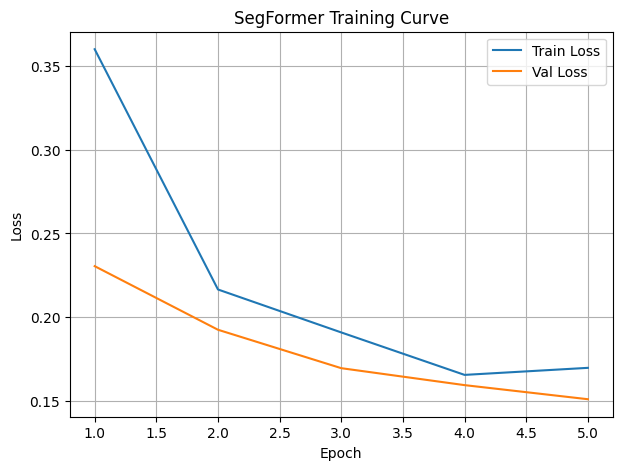

In [ ]:
import matplotlib.pyplot as plt

train_losses = [0.3598, 0.2166, 0.1910, 0.1657, 0.1699]
val_losses   = [0.2305, 0.1926, 0.1697, 0.1596, 0.1512]

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SegFormer Training Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
segformer.eval()

imgs, masks = next(iter(val_loader))
imgs  = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = segformer(pixel_values=imgs).logits
    logits_up = torch.nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    preds = (torch.sigmoid(logits_up) >= 0.5).float()

idx = 0  # first image in batch

plt.figure(figsize=(12,4))

# raw RGB (unnormalize: img = img*0.5 + 0.5)
plt.subplot(1,3,1)
plt.imshow((imgs[idx].cpu().permute(1,2,0)*0.5+0.5).clamp(0,1))
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(masks[idx].cpu().squeeze(), cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(preds[idx].cpu().squeeze(), cmap='gray')
plt.title("Prediction")
plt.axis("off")

plt.show()

NameError: name 'segformer' is not defined

Comparison of both models

In [ ]:
import torch
import torch.nn.functional as F
from scipy.stats import wilcoxon
from torchvision.models.segmentation import fcn_resnet50

# Load BOTH saved models from Google Drive

# Load ResNet baseline
resnet50_fcn = fcn_resnet50(weights=None, num_classes=1)
resnet50_fcn.load_state_dict(
    torch.load("/content/drive/MyDrive/SkyMapper/resnet50_best.pth", map_location=device)
)
resnet50_fcn.to(device)
resnet50_fcn.eval()

# Load SegFormer
segformer = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=1,
    ignore_mismatched_sizes=True
)
segformer.load_state_dict(
    torch.load("/content/drive/MyDrive/SkyMapper/segformer_epoch_5.pth", map_location=device)
)
segformer.to(device)
segformer.eval()

print("Both models loaded successfully.")

# Helper: compute F1 per image

def f1_score_per_image(pred, mask, eps=1e-8):
    pred = pred.view(-1)
    mask = mask.view(-1)

    tp = (pred * mask).sum().item()
    fp = (pred * (1 - mask)).sum().item()
    fn = ((1 - pred) * mask).sum().item()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    return f1

# 3. Run inference on test set

resnet_f1_scores = []
segformer_f1_scores = []

for imgs, masks in test_loader:
    imgs  = imgs.to(device)
    masks = (masks.to(device) > 0.5).float()

    # ResNet forward
    r_logits = resnet50_fcn(imgs)["out"]
    r_probs  = torch.sigmoid(r_logits)
    r_preds  = (r_probs > 0.5).float()

    # SegFormer forward
    s_logits = segformer(pixel_values=imgs).logits
    s_logits_up = F.interpolate(
        s_logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
    )
    s_probs = torch.sigmoid(s_logits_up)
    s_preds = (s_probs > 0.5).float()

    # Compute per-image F1
    for i in range(imgs.shape[0]):
        resnet_f1_scores.append(f1_score_per_image(r_preds[i], masks[i]))
        segformer_f1_scores.append(f1_score_per_image(s_preds[i], masks[i]))

print("Finished computing per-image F1 scores.")

# Run Wilcoxon Signed-Rank Test

stat, p = wilcoxon(segformer_f1_scores, resnet_f1_scores)
print("Wilcoxon statistic:", stat)
print("Wilcoxon p-value:", p)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


NameError: name 'device' is not defined